# CpE Elective 3 Laboratory (LBYCPC4) <br/>
#### Computer Vision and Deep Learning Elective Track
<br/>
<hr style="border:5px solid gray">


## Activity 2: Variational Autoencoders and Generative Adversarial Networks

### Introduction
&emsp;&emsp;&emsp;A Variational Autoencoder (VAE) and a Generative Adversarial Network (GAN) are both types of generative models, which are neural networks that can learn to produce new data that's similar to the data they were trained on. While they both serve this purpose, they achieve it using different architectures and training methodologies. In this activity, you will explore variational autoencoders and generative adversarial networks as generative models that has two subnetworks within itself.

Variational autoencoders (VAE) are probabilistic generative models that use a combination of encoder and decoder networks with Bayesian inference. They learn a probabilistic mapping from a data distribution to a continuous, lower-dimensional space, known as the latent space.

Generative adversarial networks (GAN) consist of two neural networks: a generator and a discriminator. The generator creates new data points, while the discriminator tries to distinguish between real and generated data. The two components are trained in an adversarial manner, improving each other over time.

### Objectives
- Understand the working principle and architecture of variational autoencoders and generative adversarial networks
- Build and train a variational autoencoder using deep learning framework
- Build and train a generative adversarial network using deep learning framework
- Visualize the output of the generative networks
- Assess the performance of the implemented generative networks

### Activity

Execute the code cells below to install the required Python packages and libraries.

In [1]:
# Import libraries
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2025-09-24 13:28:21.473796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-24 13:28:21.487793: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 13:28:22.002844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 13:28:24.387375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2.20.0
True


In [3]:
print("TensorFlow version: ", tf.__version__)
print("GPU available?", tf.config.list_physical_devices("GPU"))

TensorFlow version:  2.20.0
GPU available? []


2025-09-24 13:28:35.412789: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**A. Variational Autoencoders**

1. Acquire and preprocess the [EMNIST Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html). Image pixel values should be normalized and oriented properly. Display at least thirty (30) training images.

In [ ]:
# Import libraries
from torchvision.datasets import EMNIST

# Get the EMNIST dataset
# Normalize the image pixel values to within the range [0, 1]
# Save the training data to variable X_train as a Numpy array
# Save the testing data to variable X_test as a Numpy array
# Save the targets to variable y as a Numpy array
# Note that the images provided are inverted horizontally and
# rotated 90 anti-clockwise. It must be oriented properly
### --YOUR CODE HERE-- ###

#Data Extraction
#Had to add this cause Google Collab had a limit. Currently using WSL but saving to the Windows OS folder.
dataset_path = '/home/pj/emnist_data'
'

train = EMNIST(
    root=dataset_path,
    split = "balanced",
    train=True,
    download=True,
)
test = EMNIST(
    root=dataset_path,
    split = "balanced",
    train=False,
    download=True,
)

print("Train Len:", len(train))
print("Test Len:", len(test))

X_train, y_train, X_test, y_test = ([] for i in range(4))

#Extract train
for image, label in train:
  X_train.append(np.array(image))
  y_train.append(np.array(label))

#Extract Test
for image, label in test:
  X_test.append(np.array(image))
  y_test.append(np.array(label))

#Fixing Dataset
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#Double checking the shapes
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

#Rotating Function
def fix_emnist_orientation(images):
  fixed = []
  for img in images:
    rotated = np.rot90(img, k=1)
    flipped = np.flipud(rotated)
    fixed.append(flipped)
  return np.array(fixed)

X_train = fix_emnist_orientation(X_train)
X_test = fix_emnist_orientation(X_test)

#Get pixel value
print("Min Pixel", X_train.min())
print("Max Pixel", X_train.max())
#Max is 255
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("Min Pixel", X_train.min())
print("Max Pixel", X_train.max())

# Display the first thirty (30) images from the training split
# Place ten (10) images per row
# Each image should have a label underneath
### --YOUR CODE HERE-- ###

#Get mapping for label
mapping = [str(c) for c in train.classes]

plt.figure(figsize=(15, 5))

for i in range(30):
  plt.subplot(3, 10, i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(mapping[y_train[i]])
plt.show()

PermissionError: [Errno 13] Permission denied: '/mnt/c'

2. Build the encoder subnetwork as shown below.
<center><img src="https://drive.google.com/uc?export=view&id=17C2wrfGKn6TPdrGezFWnSJG2jlCH_hmS"></center>

In [ ]:
# Import functions and classes from Keras library
from keras import Input, Model, ops
from keras.layers import Layer, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten

# Define the latent dimensions
latent_dim = 8

# Define the Sampling layer as a custom layer
# The Sampling layer will accept two inputs
# The first input is the distribution mean
# The second input is the logarithm of the distribution variance
# The layer samples from the distribution defined by the parameters above
# Import functions and classes from Keras random module
from keras.random import SeedGenerator, normal

class Sampling(Layer):
  def __init__(self, **kwargs): # initialize the custom layer
    super().__init__(**kwargs)
    self.seed_generator = SeedGenerator(0)

  def call(self, inputs): # function definition when this layer is called
    z_mean, z_log_var = inputs
    batch = ops.shape(z_mean)[0]
    dim = ops.shape(z_mean)[1]
    epsilon = normal(shape=(batch, dim), seed=self.seed_generator)
    return z_mean + ops.exp(0.5*z_log_var)*epsilon

# Create the encoder network layers from the illustrated model plot
# Use the latent_dim variable to define the probability distribution parameters
# Save the input layer to input_img variable
# Save the mean layer output to z_mean variable
# Save the logarithm of the variance layer output to z_log_var variable
# Save the sampling layer output to z_sample variable
### --YOUR CODE HERE-- ###
input_img = Input(shape=(28, 28, 1), dtype="float32", name='Input')
x = Conv2D(32, 3, activation="relu", padding="same", name='Conv2d_0')(input_img)
x = MaxPooling2D(pool_size=2, padding="same",  name='MaxPooling2d_0')(x)
x = Conv2D(64, 3, activation="relu", padding="same",  name='Conv2d_1')(x)
x = MaxPooling2D(pool_size=2, padding="same",  name='MaxPooling2d_1')(x)
x = Flatten( name='flatten')(x)
x = Dense(64, activation='relu',  name='Dense_0')(x)
z_mean = Dense(latent_dim, name="z_mean", activation='linear')(x)
z_log_var = Dense(latent_dim, name="z_log_var", activation ='linear')(x)
z_sample = Sampling(name="z_sample")([z_mean, z_log_var])
# Create the encoder network using the layers defined above
vae_encoder = Model(input_img, [z_mean, z_log_var, z_sample], name="encoder")
vae_encoder.summary()

I0000 00:00:1758612177.344357    1131 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7535 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_0 (Conv2D)   │ (None, 28, 28,    │        320 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2d_0      │ (None, 14, 14,    │          0 │ Conv2d_0[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ MaxPooling2d_0[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2d_1      │ (None, 7, 7, 64)  │          0 │ Conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ MaxPooling2d_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_0 (Dense)     │ (None, 64)        │    200,768 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │        520 │ Dense_0[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │        520 │ Dense_0[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_sample (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 220,624 (861.81 KB)

 Trainable params: 220,624 (861.81 KB)

 Non-trainable params: 0 (0.00 B)

3. Build the decoder subnetwork as shown below.
<center><img src="https://drive.google.com/uc?export=view&id=1WaXSFDSDL_92iQQzrubMyYfYT7mlBzlz"></center>

In [ ]:
# Import functions and classes from Keras library
from keras.layers import Reshape, UpSampling2D

# Create the decoder network layers from the illustrated model plot
# Use the latent_dim variable to define the probability distribution parameters
# Save the input layer to input_latent variable
# Save the last convolutional layer output to decoded variable
### --YOUR CODE HERE-- ###
input_latent = Input(shape=(latent_dim,), dtype='float32',  name='Z_input')
decoder = Dense(3136, activation='relu',  name='Decode_1')(input_latent)
decoder = Reshape((7, 7, 64),  name='Flatten')(decoder)
decoder = Conv2D(64, 3, activation='relu', padding="same",  name='Conv2d_2')(decoder)
decoder= UpSampling2D(size=(2,2),  name='UpSample_0')(decoder)
decoder = Conv2D(32, 3, activation='relu', padding="same", name='Conv2d_3')(decoder)
decoder = UpSampling2D(size=(2,2),  name='UpSample_1')(decoder)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same',  name='Output')(decoder)

# Create the decoder network using the layers defined above
vae_decoder = Model(input_latent, decoded, name="decoder")
vae_decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Z_input (InputLayer)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decode_1 (Dense)                │ (None, 3136)           │        28,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSample_0 (UpSampling2D)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSample_1 (UpSampling2D)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Conv2D)                 │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,905 (327.75 KB)

 Trainable params: 83,905 (327.75 KB)

 Non-trainable params: 0 (0.00 B)

4. Execute the code below that will define a custom model for Variational Autoencoder and instantiate its class.

In [ ]:
# Import functions and classes from Keras library
from keras.metrics import Mean
from keras.losses import binary_crossentropy

# Define VAE as a custom model
class VAE(Model):
  def __init__(self, encoder, decoder, **kwargs): # initialize the custom layer
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    # Define loss trackers
    self.total_loss_tracker = Mean(name="total_loss")
    self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
    self.kl_loss_tracker = Mean(name="kl_loss")

  @property
  def metrics(self):  # define model metrics
    return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
            ]

  def train_step(self, data): # define training process for the model
    with tf.GradientTape() as tape:
      # Forward pass: Encode the data and decode the latent representation.
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)

      # Calculate training losses
      reconstruction_loss = ops.mean(
          ops.sum(binary_crossentropy(data, reconstruction), axis=(1, 2))
          )
      kl_loss = -0.5*(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
      kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss

    # Calculate gradients and apply update to model weights
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Update training losses
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    # Forward pass: Encode and decode the data.
    z_mean, z_log_var, z = self.encoder(data)
    reconstruction = self.decoder(z)

    # Calculate validation losses
    reconstruction_loss = ops.mean(
          ops.sum(binary_crossentropy(data, reconstruction), axis=(1, 2))
          )
    kl_loss = -0.5*(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
    kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss

    # Update validation losses
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {m.name: m.result() for m in self.metrics}

# Instantiate the VAE model with its encoder and decoder subnetworks
vae_cnn = VAE(vae_encoder, vae_decoder)

5. Configure the network for training with the appropriate loss function and an optimizer of your choice. Then train the model with a batch size of 100. Make sure to save the history of losses per training epoch.

In [ ]:
# Configure the network for training using the compile method
# Set the optimizer to your choice and determine the appropriate loss function
### --YOUR CODE HERE-- ###
from keras.layers import Activation
vae_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model. Set the batch size to 100
# Use early stopping to determine the appropriate training epochs
# Perform model hyperparameter tuning as needed
# Assign the output to hist_vae_cnn variable
### --YOUR CODE HERE-- ###
hist_vae_cnn = vae_cnn.fit(
    X_train,
    epochs = 200,
    batch_size = 100,
    verbose=1,
    validation_data=(X_test, None)
)

Epoch 1/200


2025-09-23 15:23:04.297521: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ecad8025cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-23 15:23:04.297550: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-09-23 15:23:04.364984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-23 15:23:04.931190: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-23 15:23:05.041479: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-23 15:23:05.679025: I e

  17/1128 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - kl_loss: 1.6139 - reconstruction_loss: 480.9489 - total_loss: 482.5628

I0000 00:00:1758612189.433683    1331 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1128/1128 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kl_loss: 14.0216 - reconstruction_loss: 194.2481 - total_loss: 208.2699 - val_kl_loss: 17.1040 - val_reconstruction_loss: 161.5615 - val_total_loss: 178.6654
Epoch 2/200
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 17.3308 - reconstruction_loss: 156.5288 - total_loss: 173.8596 - val_kl_loss: 17.6128 - val_reconstruction_loss: 155.1654 - val_total_loss: 172.7782
Epoch 3/200
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 17.8180 - reconstruction_loss: 151.7129 - total_loss: 169.5309 - val_kl_loss: 17.2201 - val_reconstruction_loss: 151.7633 - val_total_loss: 168.9835
Epoch 4/200
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 18.0611 - reconstruction_loss: 149.0231 - total_loss: 167.0841 - val_kl_loss: 18.1409 - val_reconstruction_loss: 148.3982 - val_total_loss: 166.5391
Epoch 5/200
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - kl_loss: 18.2393 - reconstruction_loss: 147.1595 - total_loss: 165.3990 - val_kl_loss: 18.2858

6. Plot both the training and validation losses per epoch for the following: (1) reconstruction_loss, (2) kl_loss, and (3) total_loss. Place appropriate plot title and axis labels.

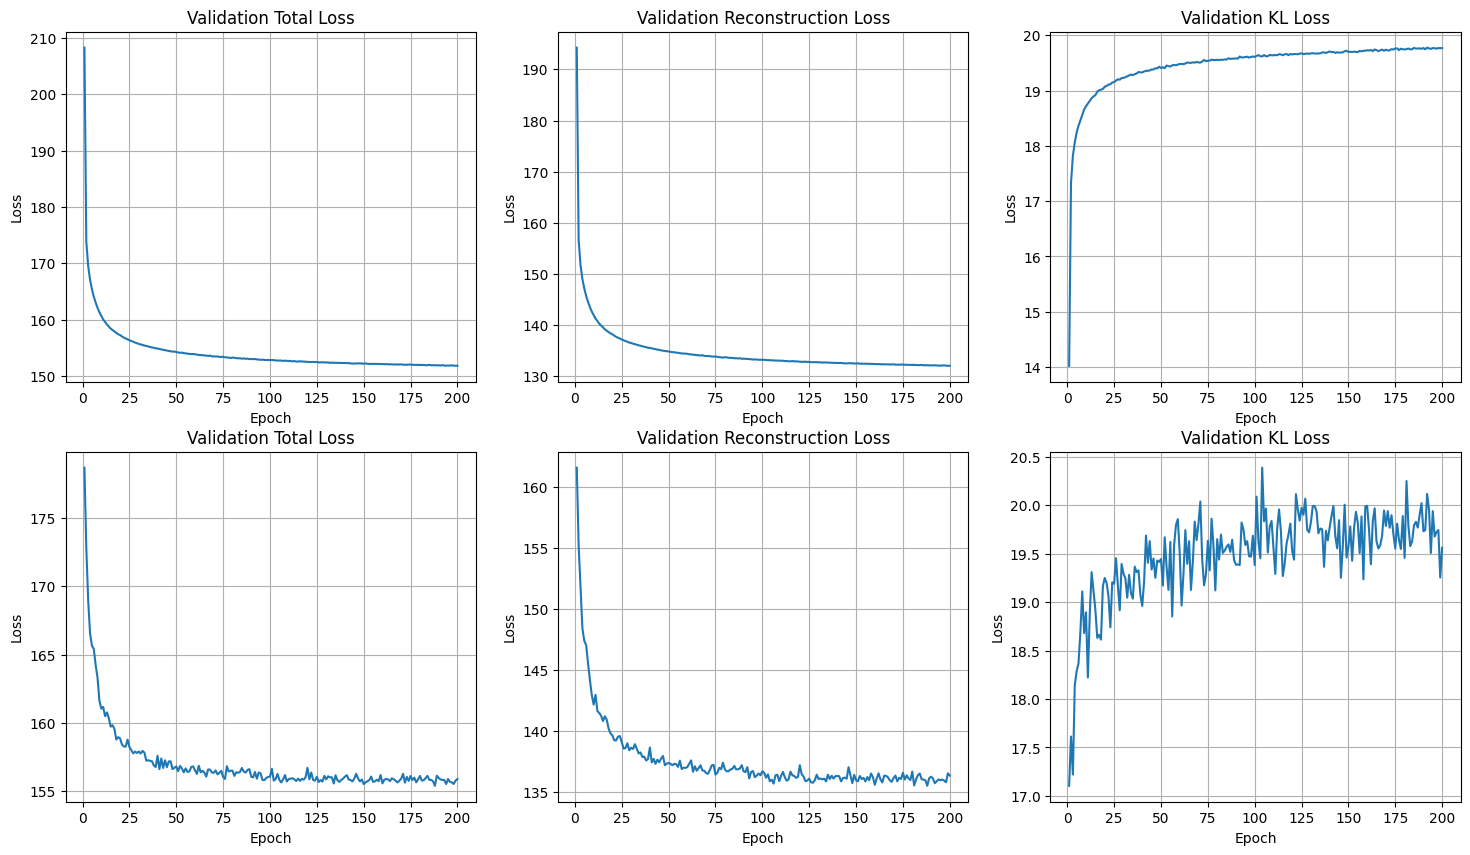

In [ ]:
# Extract the losses during training
reconstruction_losses = hist_vae_cnn.history["reconstruction_loss"]
kl_losses = hist_vae_cnn.history["kl_loss"]
losses = hist_vae_cnn.history["total_loss"]
validation_reconstruction_losses = hist_vae_cnn.history["val_reconstruction_loss"]
validation_kl_losses = hist_vae_cnn.history["val_kl_loss"]
validation_losses = hist_vae_cnn.history["val_total_loss"]
epochs = range(1, len(losses) + 1)

# Plot the history of training and validation losses
# Put the training losses subplots in the first row
# Put the validation losses subplots in the second row
### --YOUR CODE HERE-- ###
train_losses = [losses, reconstruction_losses, kl_losses]
val_losses = [validation_losses, validation_reconstruction_losses, validation_kl_losses]
titles = ["Total Loss", "Reconstruction Loss", "KL Loss"]

fig, axes = plt.subplots(2, 3, figsize=(18,10))

for i in range(3):
  axes[0, i].plot(epochs, train_losses[i])
  axes[0, i].set_title(f"Validation {titles[i]}")
  axes[0, i].set_xlabel("Epoch")
  axes[0, i].set_ylabel("Loss")
  axes[0, i].grid(True)

for i in range(3):
  axes[1, i].plot(epochs, val_losses[i])
  axes[1, i].set_title(f"Validation {titles[i]}")
  axes[1, i].set_xlabel("Epoch")
  axes[1, i].set_ylabel("Loss")
  axes[1, i].grid(True)

7. Obtain the output of the VAE for at least 15 test images. Display the input image in the first row and the reconstructed output in the second row. Compare the images and write your observations in the final report.

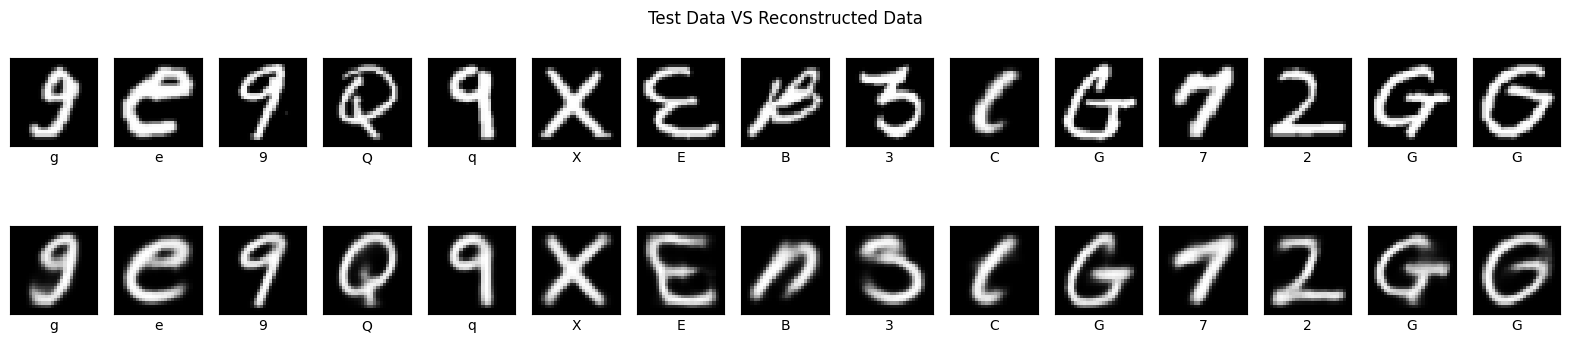

In [ ]:
# Select at least 15 test images
# Feed the test images to the encoder network. Save it to z_img variable
# Feed the encoder outputs to the decode network
### --YOUR CODE HERE-- ###

test_set = X_test[:15]
z_mean2, z_log_var2, z_img = vae_encoder(test_set)
#Reconstruction
reconstructed = vae_decoder(z_img)

# Display the selected test images in the first row
# Display the resulting images in the second row
### --YOUR CODE HERE-- ###
mapping = [str(c) for c in test.classes]

plt.figure(figsize=(20, 4))
plt.title("Test Data VS Reconstructed Data")
plt.axis('off')
for i in range(30):
  plt.subplot(2, 15, i+1)
  if i < 15:
    plt.imshow(test_set[i], cmap='gray')
  else:
    plt.imshow(reconstructed[i-15], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(mapping[y_test[i%15]])

plt.show()


8. Extract the encoder subnetwork and obtain its outputs for at least 1000 test images. With these outputs, plot the histogram for the all the latent variables. What distribution does the histograms show? Write your observations in the final report.

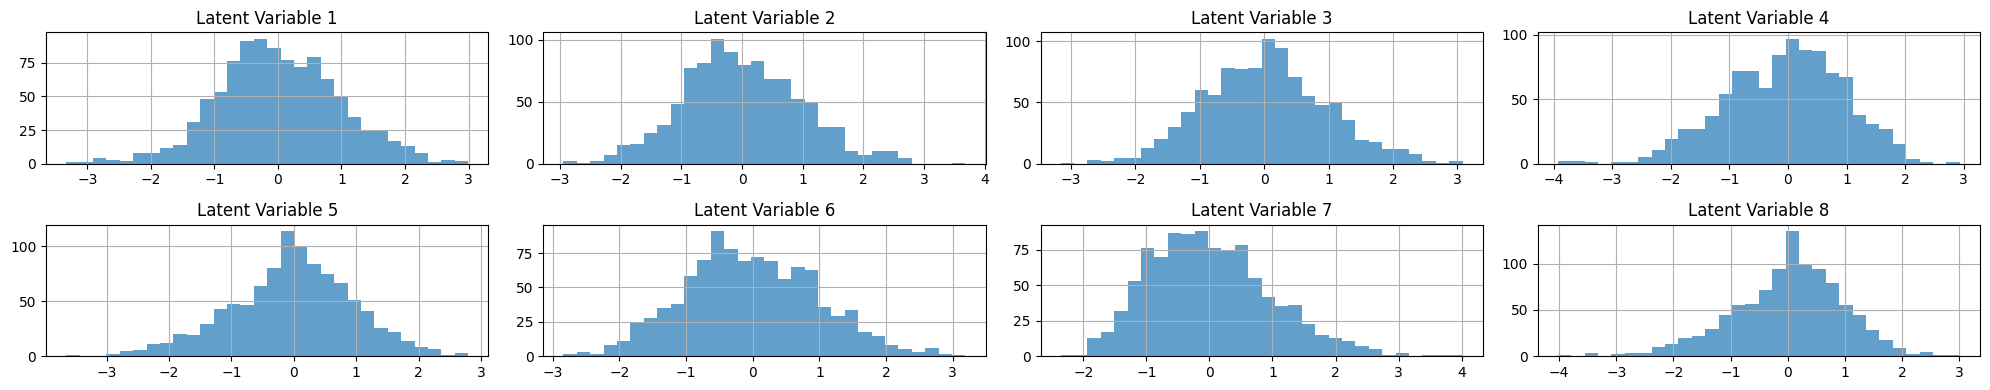

In [ ]:
# Select at least 1000 test images
# Feed the test images to the encoder network. Save it to z_lat variable
### --YOUR CODE HERE-- ###
X_sample = X_test[:1000]
z_lat, z_log_var, z_sample = vae_encoder(X_sample)

# Create a histogram for each latent space variable into subplots
# The subplots should be arrange into a grid with 2 rows and 4 columns
### --YOUR CODE HERE-- ###

plt.figure(figsize=(20, 4))
for i in range(latent_dim):
  plt.subplot(2, 4, i+1)
  plt.hist(z_lat[:,i], bins=30, alpha=0.7)
  plt.title(f"Latent Variable {i+1}")
  plt.grid(True)
plt.tight_layout()
plt.show()


9. Take the following three (3) images from the dataset: (1) a lowercase letter, (2) an uppercase letter of image 1, and (3) another uppercase letter. Obtain the encoder output for the images. Take the difference of image 1 encoder output and image 2 encoder output ($z_d = z_1 - z_2$). Afterwards, the difference shall be added to the encoder output for image 3 ($z_3'= z_3 + z_d$). Feed this as an input to the decoder network and display the resulting image. Can you make sense of the resulting image? Describe the effect of performing the latent space arithmetic and write your observations in the final report.

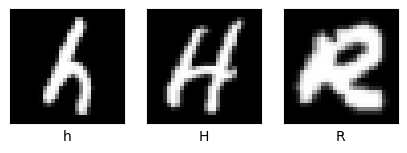

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


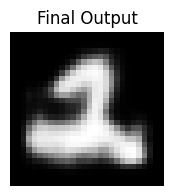

In [ ]:
# Select the test image and display them in a single row
### --YOUR CODE HERE-- ###

#Selection and Index h 99, H 55, R 15
indices = [99, 55, 15]
sample_data = np.array([X_test[i] for i in indices]) #View the Images

#Present the Data

mapping = [str(c) for c in test.classes]

plt.figure(figsize=(5, 4))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(sample_data[i], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(mapping[y_test[indices[i]]])

plt.show()

# Obtain the output of the encoder for each test image
# Save the encoder output for the first image to z1 variable
# Save the encoder output for the second image to z2 variable
# Save the encoder output for the third image to z3 variable
# Perform the difference z1 - z2 and store to zd variable
# Perform the sum z3 + zd and store to z3new variable
### --YOUR CODE HERE-- ###

z_mean, z_log_var, z = vae_encoder(sample_data)
z1, z2, z3 = z_mean[0:1], z_mean[1:2], z_mean[2:3]

zd = z1 - z2
z3new = z3 + zd
# Feed the new latent vector z3new to the decoder network
# Display the resulting image
### --YOUR CODE HERE-- ###
final_image = vae_decoder.predict(z3new)
plt.figure(figsize=(2,2))
plt.title("Final Output")
plt.imshow(final_image[0], cmap='gray') #Not fixed at all
plt.axis('off')
plt.show()


**B. Generative Adversarial Networks**

1. The code below converts the [EMNIST Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html) into a single Tensorflow Dataset format. Examine it then write the code below to display 30 images from the created Tensorflow Dataset.

100%|████████████████████████████████████████████████████████████████████████████████| 562M/562M [00:11<00:00, 50.4MB/s]


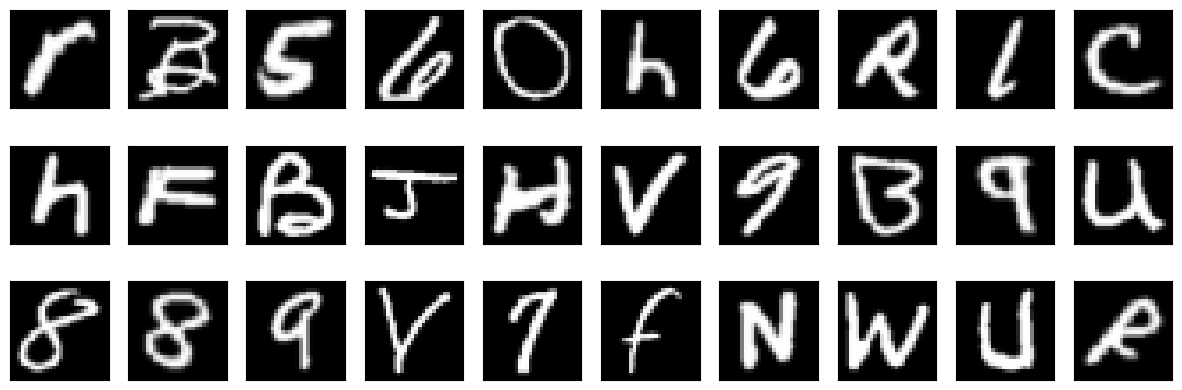

In [ ]:
# Import libraries
from torchvision import transforms
from torchvision.datasets import EMNIST

# Load the EMNIST dataset
emnist_train = EMNIST("./data", split="balanced", train=True, download=True,
                      transform=transforms.ToTensor()
                      )
emnist_test = EMNIST("./data", split="balanced", train=False, download=True,
                     transform=transforms.ToTensor()
                     )

# Define the generator function for Tensorflow dataset
def emnist_ds_generator(dataset):
  for image, _ in dataset:
    yield np.transpose(image.numpy(), axes=(0, 2, 1)).reshape(28, 28, 1)

# Define the Tensorflow dataset output signature
emnist_ds_osig = tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32)

# Create the Tensorflow dataset
emnist_ds_train = tf.data.Dataset.from_generator(
    lambda: emnist_ds_generator(emnist_train),
    output_signature=emnist_ds_osig
)
emnist_ds_test = tf.data.Dataset.from_generator(
    lambda: emnist_ds_generator(emnist_test),
    output_signature=emnist_ds_osig
)
emnist_ds = emnist_ds_train.concatenate(emnist_ds_test)
emnist_ds = emnist_ds_train.concatenate(emnist_ds_test)
emnist_ds = emnist_ds.shuffle(buffer_size=1000)

# Display 30 images from the Tensorflow dataset in three rows (10 images per row)
### --YOUR CODE HERE-- ###

iterator = emnist_ds.take(30).as_numpy_iterator()

plt.figure(figsize=(15, 5))

for i in range(30):
  img = next(iterator)
  plt.subplot(3, 10, i+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

2. Build the discriminator subnetwork as shown below.
<center><img src="https://drive.google.com/uc?export=view&id=17ZQvvO3HrEGoOMZliXsIF1xN8-nJeHoL"></center>

In [ ]:
# Import functions and classes from Keras library
from keras import Input, Sequential
from keras.layers import LeakyReLU, Dense, Dropout
from keras.layers import Conv2D, Flatten

# Create the discriminator. Save it to gan_discriminator variable
# Convolutions should have a filter size of 5 and a stride of 2
# Dropout rate is set to 0.3
### --YOUR CODE HERE-- ###
gan_discriminator = Sequential([
    Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=(28, 28, 1), name="Conv2D"),
    LeakyReLU(name='LeakyReLu'),
    Dropout(0.3, name='Dropout'),
    Conv2D(128,(5,5), strides=(2,2), padding='same', input_shape=(28, 28, 1), name="Conv2D_1"),
    LeakyReLU(name='LeakyReLu_1'),
    Dropout(0.3, name='Dropout_1'),
    Flatten(name='Flatten'),
    Dense(1, activation = 'linear', name='Dense')
])

gan_discriminator.summary()

/home/steven/tf_gpu_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LeakyReLu (LeakyReLU)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LeakyReLu_1 (LeakyReLU)         │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

3. Build the generator subnetwork as shown below.
<center><img src="https://drive.google.com/uc?export=view&id=1zavLw3Ay_PfMASnpzz6f9stSfQG3F9vT"></center>

In [ ]:
# Import functions and classes from Keras library
from keras import Input, Sequential
from keras.layers import LeakyReLU, Dense
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization

# Specify the latent space dimension
latent_dim = 128

# Create the generator. Save it to gan_generator variable
# Transpose convolutions should have a filter size of 5
# The first transpose convolution has stride of 1. Others have stride of 2
### --YOUR CODE HERE-- ###
gan_generator = Sequential([
    Dense(7*7*256, input_shape=(latent_dim,), name='Dense_1'),
    BatchNormalization(name="Batch_Normalization"),
    LeakyReLU(name='Leaky_ReLu_2'),
    Reshape((7, 7, 256),name='reshape'),
    Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', name='Conv2D_Transpose'),
    BatchNormalization(name="Batch_Normalization_1"),
    LeakyReLU(name='Leaky_ReLu_3'),
    Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', name='Conv2D_Transpose_1'),
    BatchNormalization(name="Batch_Normalization_2"),
    LeakyReLU(name='Leaky_ReLu_4'),
    Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', name='Conv2D_Transpose_2')
])
gan_generator.summary()

/home/steven/tf_gpu_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 12544)          │     1,618,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_ReLu_2 (LeakyReLU)        │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Transpose                │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_ReLu_3 (LeakyReLU)        │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Transpose_1              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_ReLu_4 (LeakyReLU)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,694,913 (10.28 MB)

 Trainable params: 2,669,441 (10.18 MB)

 Non-trainable params: 25,472 (99.50 KB)

4. Execute the code below that will define a custom model for GAN and instantiate its class.

In [ ]:
# Import functions and classes from Keras library
from keras import Model, ops

# Define GAN as a custom model
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.seed_generator = keras.random.SeedGenerator(1337)

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # If input is a tuple, get the first element
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images],
                                          axis=0)

        # Assemble labels discriminating real from fake images.
        # Use one-sided label smoothing for the "real" labels.
        labels = ops.concatenate([ops.full((batch_size, 1), 0.9),
                            ops.zeros((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply(grads, self.discriminator.trainable_weights)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply(grads, self.generator.trainable_weights)

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

# Instantiate the GAN model
gan = GAN(discriminator=gan_discriminator,
          generator=gan_generator,
          latent_dim=latent_dim)

5. Configure the network for training with the appropriate loss function and an optimizer of your choice. Then train the model with a batch size of 100. Make sure to save the history of losses per training epoch.

In [ ]:
# Configure the network for training
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

gan.compile(
    d_optimizer=Adam(learning_rate=0.00005, beta_1=0.5, beta_2=0.99, epsilon=1e-7),
    g_optimizer=Adam(learning_rate=0.0003, beta_1=0.5, beta_2=0.99, epsilon=1e-7),
    loss_fn=BinaryCrossentropy(from_logits=True),
) # You may add more optimizer parameters for tuning the training process

# Train the model. Set the dataset batch size to 100
# You may take 100 batches only to speed up the training
# Assign the output to gan_hist variable
### --YOUR CODE HERE-- ###
gan_hist = gan.fit(
    emnist_ds.batch(100).repeat(),
    epochs = 20,
    steps_per_epoch=len(emnist_train)//100,
    verbose = 1
)

Epoch 1/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - d_loss: 0.5495 - g_loss: 1.3124
Epoch 2/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - d_loss: 0.5276 - g_loss: 1.3632
Epoch 3/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - d_loss: 0.4295 - g_loss: 1.5695
Epoch 4/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - d_loss: 0.6229 - g_loss: 1.1822
Epoch 5/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - d_loss: 0.5203 - g_loss: 1.3528
Epoch 6/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - d_loss: 0.5091 - g_loss: 1.3823
Epoch 7/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - d_loss: 0.5327 - g_loss: 1.3107
Epoch 8/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - d_loss: 0.5539 - g_loss: 1.2493
Epoch 9/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - d_loss: 0.5621 - g_loss: 1.2462
Epoch 10/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - d_loss: 0.5652 - g_loss: 1.2163
Epoch 11/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - d_loss: 0.5214 - g_loss: 1.3472
Epoch 12

6. Plot the generator and discriminator losses per epoch. Place appropriate plot title and axis labels.

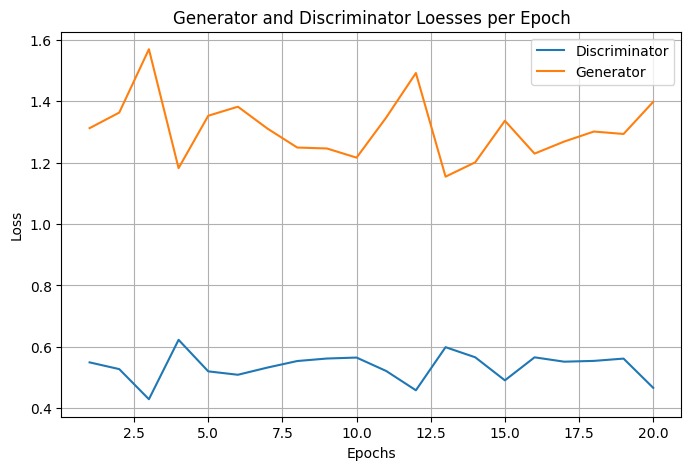

In [ ]:
# Extract the losses during training
dis_losses = gan_hist.history["d_loss"]
gen_losses = gan_hist.history["g_loss"]
epochs = range(1, len(dis_losses) + 1)

# Plot the history of training and validation losses
### --YOUR CODE HERE-- ###
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loesses per Epoch")
plt.plot(epochs, dis_losses, label = "Discriminator")
plt.plot(epochs, gen_losses, label = "Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

7. Feed the generator network with at least 30 random inputs. How many of these images resembles a valid handwritten symbol? Afterwards, add a small random offset to the initial inputs and feed it to the generator network once again. How did the output images changed? Display all output images and write your observations in the final report.

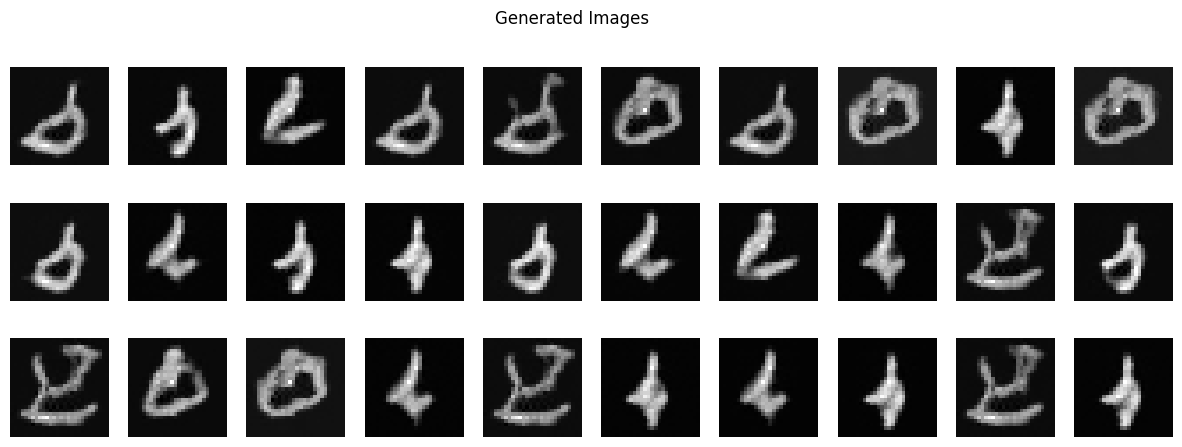

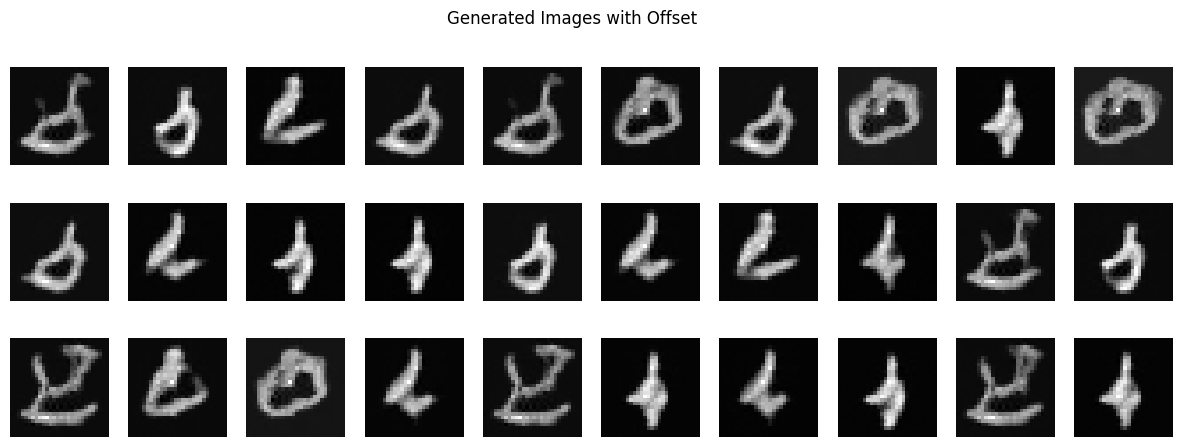

In [ ]:
# Import functions and classes from Keras library
from keras.random import normal

# Generate 30 random 128-dimensional vectors as input
# Feed the random inputs to the generator network
# Display the output images of the generator
### --YOUR CODE HERE-- ###
vectors = normal(shape=(30, latent_dim))
#image generation step
generated = gan_generator(vectors).numpy()

#plotting
plt.figure(figsize=(15,5))
for i in range(30):
  plt.subplot(3,10,i+1)
  plt.imshow(generated[i], cmap="gray")
  plt.axis("off")
plt.suptitle("Generated Images")
plt.show()

# Add a small random offsets to the initial inputs
# Feed the new input to the generator network
# Display the new output images of the generator
### --YOUR CODE HERE-- ###
noise = np.random.normal(0, 0.1, size = vectors.shape)
vectors_offset = vectors + noise
generated_offset = gan_generator(vectors_offset).numpy()

plt.figure(figsize=(15,5))
for i in range(30):
  plt.subplot(3,10,i+1)
  plt.imshow(generated_offset[i], cmap="gray")
  plt.axis("off")
plt.suptitle("Generated Images with Offset")
plt.show()


***

### Machine Problems

1. Generative adversarial networks generate images based purely on random noise, which means the user has little control over what type of image is generated. On the other hand, Conditional GANs (CGAN) [7] allow you to condition the image generation process on additional information, such as class labels or other data features. Train a CGAN with the EMNIST dataset so that the generated character can be controlled.  You may refer to these tutorials as a guide: [1](https://keras.io/examples/generative/conditional_gan/), [2](https://www.kaggle.com/code/arturlacerda/pytorch-conditional-gan/notebook).

    Show the plot of discriminator and generator losses per epoch during training. Perform hyperparameter tuning of the networks and document the results. Generate 5 images each from at least 10 different characters.

<center><img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/0*SXRW2IxUeDxpPj7j.png"></center>

### References

[1] Aggarwal, Charu C. (2023). *Neural Networks and Deep Learning : A Textbook*. 2nd ed. Cham: Springer International Publishing.

[2] Chollet, F. et al., (2025). *Keras 3 API documentation*. Retrieved from https://keras.io/api/

[3] Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). *EMNIST: an extension of MNIST to handwritten letters*. Retrieved from http://arxiv.org/abs/1702.05373

[4] Kingma, D., & Welling, M. (2013). *Auto-Encoding Variational Bayes*. Retrieved from https://arxiv.org/abs/1312.6114

[5] Goodfellow, I., Bengio, Y., & Courville, A. (2016) *Deep Learning*. MIT Press.

[6] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). *Generative Adversarial Networks*. Retrieved from https://arxiv.org/abs/1406.2661

[7] Mirza, M., & Osindero, S. (2014). *Conditional Generative Adversarial Nets*. Retrieved from https://arxiv.org/abs/1411.1784v1